In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import sgGSEA as sg
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import json
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'sgGSEA'

In [2]:
# choose problem: "ibd" or "pd"
problem = "ibd"
base_path = f"/data_nfs/je30bery/hiwi/data/{problem}"

In [3]:
problem

'ibd'

In [3]:
# load fpkm values
expression_matrix = list()
for f in os.listdir(base_path):
    expression_df = sg.fpkm_expression_matrix(os.path.join(base_path, f))
    expression_matrix.append(expression_df)
expression_matrix = pd.concat(expression_matrix, axis=1)

In [4]:
# drop duplicate samples
expression_matrix = expression_matrix.T.drop_duplicates().T
# drop genes with NAN values in expression -> genes that were not analyzed for all samples
expression_matrix = expression_matrix.dropna()
# perform f(x)=log(x+1), +1 to avoid -np.inf values for zeroes 
expression_matrix_log = np.log1p(expression_matrix.astype(float))

In [5]:
# use PCA
pca = PCA(2)
transformed = pca.fit_transform(expression_matrix_log.T)

In [6]:
# load label mappings
with open('./PCA/mappings.json', 'r') as json_file:
    label_mapping  = json.load(json_file)[problem]#
# map labels
expression_matrix.columns = [label_mapping["_".join(c.split("_")[:-1])] for c in expression_matrix.columns]

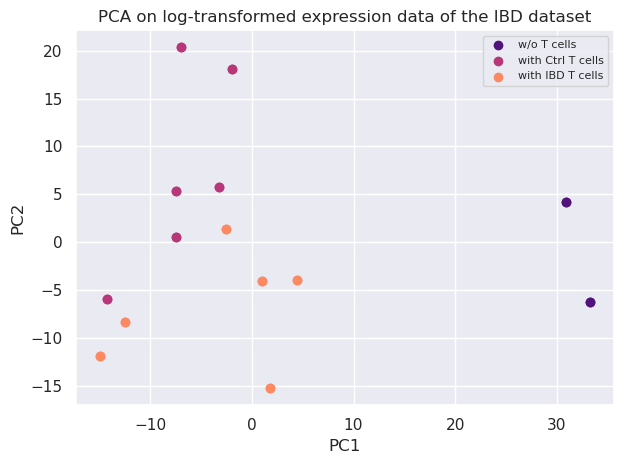

In [7]:
# plot and color by label, save plot
sns.set_theme("notebook")
pal = sns.color_palette("magma", len(np.unique(expression_matrix.columns)))
for i, condition in enumerate(np.unique(expression_matrix.columns)):
    condition_samples = transformed[np.where(expression_matrix.columns == condition)]
    plt.scatter(condition_samples[:,0], condition_samples[:,1], label=condition, color=pal[i])
plt.legend(fontsize=8)
plt.title(f"PCA on log-transformed expression data of the {problem.upper()} dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(f"/data_nfs/je30bery/hiwi/sgGSEA/PCA/pca_{problem}.pdf")

In [8]:
# get the top N features for each principal component
N=100
loadings = pca.components_
loadings_df = pd.DataFrame(loadings, columns=expression_matrix_log.T.columns)

for i in range(len(loadings_df)):
    top_features = loadings_df.iloc[i].sort_values(ascending=False).head(N)
    top_features.to_csv(f"/data_nfs/je30bery/hiwi/sgGSEA/PCA/{problem.upper()}_top_features_PC_{i}")